# Use of 3 different methods for tweets classification (NB, SVM, LSTM)

#### Necessary packages

In [47]:
# Standard library imports
from collections import Counter

# Third-party imports
import matplotlib.pyplot as plt
import nltk
import re
import sklearn
import torch
import torch.nn as nn
import torchtext.vocab as vocab
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn import svm


In [48]:
# Define test sets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']

In [49]:
def get_labels(dataset):
    """
    Extracts labels for each tweet from the dataset.

    This function reads a file where each line represents a tweet, 
    with fields separated by tabs. It extracts the tweet ID and 
    its corresponding label (ground truth) from each line.

    Args:
    dataset (str): The file path to the dataset.

    Returns:
    dict: A dictionary mapping tweet IDs to their labels.
    """
    id_gts = {}
    with open(dataset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid, gt = fields[0], fields[1]
            id_gts[tweetid] = gt
    return id_gts

def get_tweets(dataset):
    """
    Extracts tweets from the dataset.

    Similar to get_labels, this function reads the same file, 
    but instead extracts the tweet text associated with each tweet ID.

    Args:
    dataset (str): The file path to the dataset.

    Returns:
    dict: A dictionary mapping tweet IDs to the tweet texts.
    """
    id_tweets = {}
    with open(dataset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            id, tweet = fields[0], fields[2]
            id_tweets[id] = tweet
    return id_tweets

#### Pre Processing functions

Reading the data and extracting Labels and Tweets linked to IDS.

In [50]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Initialize a set of English stop words and a tweet tokenizer
stop_words = set(stopwords.words('english'))
tokenizer = TweetTokenizer()

def preprocess_tweet(tweet):
    """
    Preprocess a single tweet.

    This function performs several operations to clean and normalize the text of a tweet:
    - Converts to lowercase.
    - Removes URLs, Twitter handles, hashtags, whole numbers, and special characters.
    - Reduces repetitive characters in words.
    - Tokenizes the tweet and filters out stop words and non-alphanumeric words.
    
    Args:
    tweet (str): A string containing the tweet text.

    Returns:
    str: The preprocessed tweet text.
    """
    tweet = tweet.lower()
    tweet = re.sub(r'http\S+|www\.\S+|https\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@[\w_]+|#\S+', '', tweet)
    tweet = re.sub(r'\b\d+\b', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'\b\w\b', '', tweet)
    tweet = re.sub(r'(\w)\1{2,}', r'\1', tweet)
    tweet_tokens = tokenizer.tokenize(tweet)
    filtered_words = [word for word in tweet_tokens if word not in stop_words and word.isalnum()]

    return ' '.join(filtered_words).strip()

def preProcess(data):
    """
    Preprocess each tweet in a dataset.

    Args:
    data (dict): A dictionary mapping tweet IDs to tweet texts.

    Returns:
    dict: A dictionary with tweet IDs mapped to preprocessed tweet texts.
    """
    for tweetid, tweet in data.items():
        data[tweetid] = preprocess_tweet(tweet)
    return data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zobno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zobno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Encode labels functions

In [51]:
# Global variable for label encoder to avoid fitting every time
global_label_encoder = LabelEncoder()

def fit_label_encoder(labels):
    """
    Fits the global label encoder with the given labels.

    This function should be called before using the encoder to transform
    or inverse-transform labels.

    Args:
    labels (list): The list of labels to fit the encoder.
    """
    global global_label_encoder
    global_label_encoder.fit(labels)

def encode_labels(labels):
    """
    Encodes labels using the global label encoder with a custom label mapping.

    This function maps the encoded labels to a set of specified integer values.

    Args:
    labels (list): The list of labels to be encoded.

    Returns:
    list: Encoded labels mapped to {-1, 0, 1}.
    """
    integer_encoded = global_label_encoder.transform(labels)
    label_map = {0: -1, 1: 0, 2: 1}
    return [label_map[label] for label in integer_encoded]

def decode_labels(encoded_labels):
    """
    Decodes the encoded labels to their original string representations.

    This function uses a custom mapping for decoding.

    Args:
    encoded_labels (list): The list of encoded labels to be decoded.

    Returns:
    list: Decoded labels as string representations.
    """
    label_map = {-1: 'negative', 0: 'neutral', 1: 'positive'}
    return [label_map[label] for label in encoded_labels]

def encode_labels_lstm(labels):
    """
    Encodes labels for LSTM using the global label encoder.

    This function is specifically for LSTM models, directly returning
    the integer encoded labels.

    Args:
    labels (list): The list of labels to be encoded.

    Returns:
    list: Integer encoded labels.
    """
    return global_label_encoder.transform(labels)

def decode_labels_lstm(encoded_labels):
    """
    Decodes LSTM model's encoded labels to their original string representations.

    Assumes the global_label_encoder is fitted with 3 classes: 'negative', 'neutral', 'positive'.

    Args:
    encoded_labels (list): The list of encoded labels from an LSTM model.

    Returns:
    list: Decoded labels as string representations.
    """
    return global_label_encoder.inverse_transform(encoded_labels)

#### Lemmatization

In [52]:
# Download necessary NLTK resources
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Global lemmatizer object
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """
    Maps treebank POS tags to WordNet POS tags.

    Args:
    treebank_tag (str): A POS tag from the Penn Treebank tagset.

    Returns:
    str: The corresponding WordNet POS tag.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to NOUN

def lemmatize_with_pos(text):
    """
    Lemmatizes a given text using POS tags.

    This function tokenizes the input if it's a string and then lemmatizes
    each word based on its POS tag. In case of an error, it returns the original input.

    Args:
    text (str or list): The text to lemmatize, either as a string or as a list of words.

    Returns:
    list: A list of lemmatized words.
    """
    if isinstance(text, str):
        text = word_tokenize(text)

    try:
        pos_tagged = nltk.pos_tag(text)
        lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for word, pos_tag in pos_tagged]
        return lemmatized
    except Exception as e:
        print(f"Error during lemmatization: {e}")
        return text  # Return the original input in case of error


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zobno\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zobno\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Checking the frequencty of the words to see if the preprocess was correct.

[('tomorrow', 703), ('go', 490), ('day', 384), ('may', 376), ('get', 366), ('saturday', 256), ('im', 247), ('sunday', 234), ('night', 232), ('see', 232), ('time', 222), ('come', 221), ('1st', 184), ('friday', 176), ('make', 169), ('like', 169), ('game', 163), ('2nd', 146), ('one', 142), ('good', 141)]


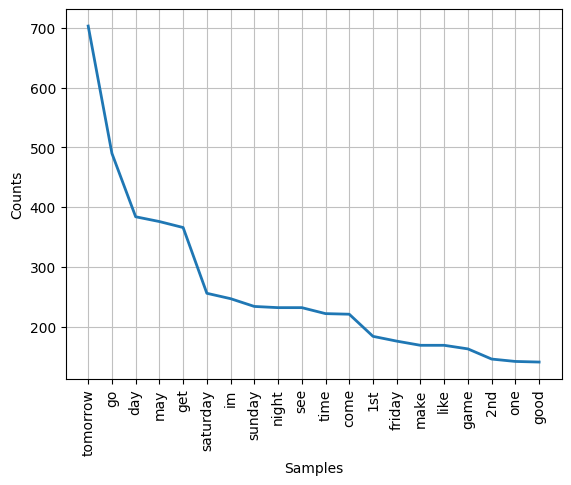

<Axes: xlabel='Samples', ylabel='Counts'>

In [53]:
# Load the test data from a file
test_data = get_tweets('twitter-test1.txt')

# Preprocess the test data
test_data = preProcess(test_data)

# Lemmatize the sentences in the test data
test_list = [lemmatize_with_pos(sentences) for sentences in test_data.values()]

# Flatten the list of lists into a single list of words
all_words = [word for wordList in test_list for word in wordList]

# Create a frequency distribution of the words
nlp_words = nltk.FreqDist(all_words)

# Find the most common 50 words
mc = nlp_words.most_common(20)
print(mc)

# Plot the frequency distribution of the top 20 words
nlp_words.plot(20)

#### Naive Bayes

In [54]:
# Load the datasets
test_data = get_tweets('twitter-test1.txt')
test_labels = get_labels('twitter-test1.txt')
train_data = get_tweets('twitter-training-data.txt')
train_labels = get_labels('twitter-training-data.txt')

# Fit the global label encoder with all possible labels
all_labels = list(train_labels.values()) + list(test_labels.values())
fit_label_encoder(all_labels)

# Preprocess the train and test data
train_data = preProcess(train_data)
test_data = preProcess(test_data)

# Convert the data and labels into lists
test_x = list(test_data.values())
test_y = list(test_labels.values())
train_x = list(train_data.values())
train_y = list(train_labels.values())

# Encode the labels using the global label encoder
testLabels = encode_labels(test_y)
train_y = encode_labels(train_y)

# Lemmatization of the training and test data
train_x = [" ".join(lemmatize_with_pos(sentence)) for sentence in train_x]
test = [" ".join(lemmatize_with_pos(sentence)) for sentence in test_x]

# Splitting the training data for validation
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.10, random_state=10)

# Create and train a pipeline with TfidfVectorizer and MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(use_idf=True, ngram_range=(1, 2))),
    ('nb', MultinomialNB(alpha=1.0))
])
pipeline.fit(x_train, y_train)

# Predict on test data
y_pred = pipeline.predict(test)

# Decode predictions to original label format
decoded_y_pred = decode_labels(y_pred)

# Calculate and print the F1 Score
f1 = f1_score(test_y, decoded_y_pred, average='weighted')
print(f"F1 Score on Test Set: {f1}")

F1 Score on Test Set: 0.4956804203824301


#### SVM

In [55]:
# Load the datasets
test_data = get_tweets('twitter-test1.txt')
test_labels = get_labels('twitter-test1.txt')
train_data = get_tweets('twitter-training-data.txt')
train_labels = get_labels('twitter-training-data.txt')

# Fit the global label encoder with all possible labels
all_labels = list(train_labels.values()) + list(test_labels.values())
fit_label_encoder(all_labels)

# Preprocess the train and test data
train_data = preProcess(train_data)
test_data = preProcess(test_data)

# Convert the data and labels into lists
test_x = list(test_data.values())
test_y = list(test_labels.values())
train_x = list(train_data.values())
train_y = list(train_labels.values())

# Encode the labels using the global label encoder
testLabels = encode_labels(test_y)
train_y = encode_labels(train_y)

# Lemmatization of the training and test data
train_x = [" ".join(lemmatize_with_pos(sentence)) for sentence in train_x]
test = [" ".join(lemmatize_with_pos(sentence)) for sentence in test_x]

# Split the training data for model training and validation
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.10, random_state=10)

# Create and train a pipeline with TfidfVectorizer and LinearSVC
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(use_idf=True, ngram_range=(1, 3))),
    ('svm', svm.LinearSVC(C=1.0))
])
pipeline.fit(x_train, y_train)

# Validate the model and print the classification report
y_val_pred = pipeline.predict(x_val)
print("Validation Metrics:")
print(classification_report(y_val, y_val_pred))

# Predict on test data
y_pred = pipeline.predict(test)

# Decode predictions to original label format
decoded_y_pred = decode_labels(y_pred)

# Calculate and print the F1 Score
f1 = f1_score(test_y, decoded_y_pred, average='weighted')
print(f"F1 Score on Test Set: {f1}")

Validation Metrics:
              precision    recall  f1-score   support

          -1       0.60      0.49      0.54       839
           0       0.66      0.63      0.64      2077
           1       0.63      0.74      0.68      1595

    accuracy                           0.64      4511
   macro avg       0.63      0.62      0.62      4511
weighted avg       0.64      0.64      0.64      4511

F1 Score on Test Set: 0.6352569681179637


### Class Weights Function

In [56]:
def compute_class_weights(labels):
    """
    Compute class weights inversely proportional to class frequencies in the dataset.
    
    Args:
    labels (list): List of all labels in the training dataset.

    Returns:
    torch.Tensor: A tensor of class weights
    """
    # Encode labels to integers
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)

    # Count the number of occurrences of each class
    class_counts = Counter(encoded_labels)

    # Compute class weights
    num_classes = len(le.classes_)
    class_weights = [len(labels) / (num_classes * class_counts[i]) for i in range(num_classes)]
    
    return torch.tensor(class_weights, dtype=torch.float32)

#### LSTM

In [57]:
# Load pretrained GloVe embeddings
glove_embeddings = vocab.GloVe(name='6B', dim=300)
glove_dict = {word: glove_embeddings.vectors[glove_embeddings.stoi[word]] for word in glove_embeddings.itos}

# Load and preprocess the datasets
test_data = get_tweets('twitter-test1.txt')
test_labels = get_labels('twitter-test1.txt')
validation_data = get_tweets('twitter-dev-data.txt')
validation_labels = get_labels('twitter-dev-data.txt')
train_data = get_tweets('twitter-training-data.txt')
train_labels = get_labels('twitter-training-data.txt')

train_data = preProcess(train_data)
test_data = preProcess(test_data)
validation_data = preProcess(validation_data)

# Fit the global label encoder with all possible labels
all_labels = list(train_labels.values())
fit_label_encoder(all_labels)

# Prepare the data for training, testing, and validation
test_list = list(test_data.values())
test_labels = list(test_labels.values())
validation_x = list(validation_data.values())
validation_y =list(validation_labels.values())
train_x = list(train_data.values())
train_y = list(train_labels.values())

# Encode the labels for LSTM
test_labels = encode_labels_lstm(test_labels)
train_y = encode_labels_lstm(train_y)
validation_y = encode_labels_lstm(validation_y)

# Lemmatization of the datasets
train_x = [lemmatize_with_pos(sentences) for sentences in train_x]
test_list = [lemmatize_with_pos(sentences) for sentences in test_list]
validation_x = [lemmatize_with_pos(sentences) for sentences in validation_x]

# Create a set of all unique words in the training datasets
all_words = set(word for sentence in train_x for word in sentence)

# Initialize the word-to-index mapping, starting with <unk>
word_to_index = {"<unk>": 0}

# Create the vocabulary only with words that are in GloVe, starting from index 1
for word in all_words:
    if word in glove_dict:
        word_to_index[word] = len(word_to_index)

# Prepare the embeddings matrix
vocab_size = len(word_to_index)
weights_matrix = torch.zeros(vocab_size, 300)
for word, index in word_to_index.items():
    weights_matrix[index] = glove_dict.get(word, torch.zeros(300))

# Convert the input data into word indices
train_x_indices = [[word_to_index.get(word, word_to_index["<unk>"]) for word in sentence] for sentence in train_x]
testList_indices = [[word_to_index.get(word, word_to_index["<unk>"]) for word in sentence] for sentence in test_list]
validation_x_indices = [[word_to_index.get(word, word_to_index["<unk>"]) for word in sentence] for sentence in validation_x]

# Padding the sequences
train_x_indices_padded = nn.utils.rnn.pad_sequence([torch.LongTensor(indices) for indices in train_x_indices], batch_first=True)
testList_indices_padded = nn.utils.rnn.pad_sequence([torch.LongTensor(indices) for indices in testList_indices], batch_first=True)
validation_x_indices_padded = nn.utils.rnn.pad_sequence([torch.LongTensor(indices) for indices in validation_x_indices], batch_first=True)

# Define the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 16
hidden_size = 64
num_layers = 3
dropout_prob = 0.4
output_size = 3
learning_rate = 0.0001
num_epochs = 50
input_size = 300
weight_decay = 0.0001

# Define the LSTM model architecture
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, weights_matrix, dropout_prob, num_layers=num_layers):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze=True)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                            batch_first=True, bidirectional=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.attention = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        lstm_out, _ = self.lstm(x)

        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = attention_weights * lstm_out
        context_vector = torch.sum(context_vector, dim=1)

        out = self.dropout(context_vector)
        out = self.fc(out)
        return torch.log_softmax(out, dim=-1)
    
# Prepare data loaders
labelsT = torch.tensor(train_y, dtype=torch.long)
train_dataset = torch.utils.data.TensorDataset(train_x_indices_padded, labelsT)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validationLabels = torch.tensor(validation_y, dtype=torch.long)
validation_dataset = torch.utils.data.TensorDataset(validation_x_indices_padded, validationLabels)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

test_labelsT = torch.tensor(test_labels, dtype=torch.long)
test_dataset = torch.utils.data.TensorDataset(testList_indices_padded, test_labelsT)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Initialization of the model with our hyperparameters.
nn_model = LSTM(input_size, hidden_size, output_size,weights_matrix, dropout_prob).to(device)

# Define loss function and optimizer
class_weights = compute_class_weights(train_y)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device)) 
optimizer = torch.optim.AdamW(nn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Training loop with early stopping
best_val_loss = float('inf')
patience, trials = 5, 0
loss_values = []

for epoch in range(num_epochs): 
    nn_model.train()
    train_loss, train_correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = nn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)
        train_correct += torch.sum(preds == labels.data)

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct.double() / len(train_loader.dataset)

    # Validation phase
    nn_model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = nn_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_correct += torch.sum(preds == labels.data)
        val_loss /= len(validation_loader.dataset)
        val_acc = val_correct.double() / len(validation_loader.dataset)

    # Update scheduler
    scheduler.step(val_loss)

    # Early stopping and model checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save model state
        torch.save(nn_model.state_dict(), 'best_model_state.pth')
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print("Early stopping triggered")
            break

    loss_values.append(val_loss)
    print(f'Epoch: [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.4f}')

Epoch: [1/50], Train Loss: 0.9406, Train Acc: 0.5060, Valid Loss: 0.8342, Valid Acc: 0.5765
Epoch: [2/50], Train Loss: 0.8620, Train Acc: 0.5657, Valid Loss: 0.8044, Valid Acc: 0.5850
Epoch: [3/50], Train Loss: 0.8427, Train Acc: 0.5824, Valid Loss: 0.7971, Valid Acc: 0.5765
Epoch: [4/50], Train Loss: 0.8284, Train Acc: 0.5889, Valid Loss: 0.7771, Valid Acc: 0.6080
Epoch: [5/50], Train Loss: 0.8124, Train Acc: 0.6013, Valid Loss: 0.7702, Valid Acc: 0.6205
Epoch: [6/50], Train Loss: 0.8006, Train Acc: 0.6050, Valid Loss: 0.7704, Valid Acc: 0.6140
Epoch: [7/50], Train Loss: 0.7929, Train Acc: 0.6123, Valid Loss: 0.7568, Valid Acc: 0.6205
Epoch: [8/50], Train Loss: 0.7839, Train Acc: 0.6144, Valid Loss: 0.7494, Valid Acc: 0.6305
Epoch: [9/50], Train Loss: 0.7745, Train Acc: 0.6216, Valid Loss: 0.7611, Valid Acc: 0.6345
Epoch: [10/50], Train Loss: 0.7689, Train Acc: 0.6224, Valid Loss: 0.7446, Valid Acc: 0.6200
Epoch: [11/50], Train Loss: 0.7596, Train Acc: 0.6299, Valid Loss: 0.7421, Vali

## Test Model

In [60]:
# Initialize lists to store predictions and true labels
test_predictions = []
true_labels = []

# Set the model to evaluation mode
nn_model.eval()

# Disable gradient calculations for efficiency
with torch.no_grad():
    # Iterate over batches of test data
    for inputs, labels in test_loader:
        # Move data to the appropriate device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate model predictions
        outputs = nn_model(inputs)
        preds = torch.argmax(outputs, dim=1)

        # Store predictions and true labels
        test_predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Decode numerical predictions back to original label format
decoded_test_predictions = decode_labels_lstm(test_predictions)

# Convert true labels from numerical back to original labels
decoded_true_labels = decode_labels_lstm(true_labels)

# Calculate and print the F1 Score and Accuracy
f1 = f1_score(decoded_true_labels, decoded_test_predictions, average='weighted')
accuracy = accuracy_score(decoded_true_labels, decoded_test_predictions)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")


F1 Score: 0.6640021573817402
Accuracy: 0.6649674313225715


## Plot Loss

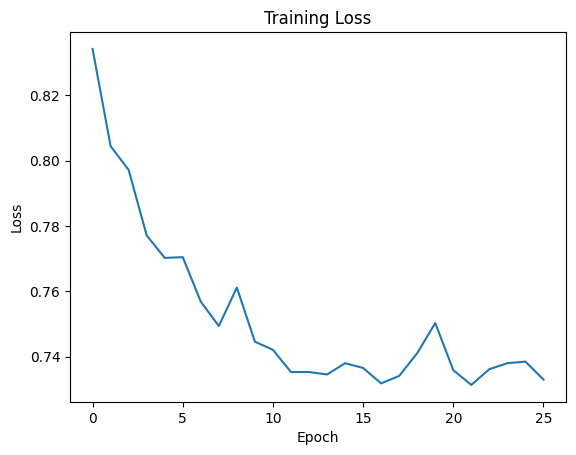

In [61]:
# Plot the training loss values
plt.plot(loss_values)
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.title('Training Loss')  # Title of the plot
plt.show()  # Display the plot
